In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 2.9 MB 9.5 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 3.3 MB 40.3 MB/s 
     |████████████████████████████████| 636 kB 34.2 MB/s 
     |████████████████████████████████| 895 kB 30.5 MB/s 
     |████████████████████████████████| 1.2 MB 10.6 MB/s 


In [2]:
import pandas as pd

import sys
# For running via Colab
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from bert_finetuner import *
from plotting_helper import *

In [3]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
#data = pd.read_json('https://raw.githubusercontent.com/pradeep-miriyala/multi-modal-bert-models/main/data/song_lyric_map.json?token=ADXRNFRS46PTRG46WUZLXHDBKH7HY')
IMG_PATH = '/content/drive/MyDrive/melSpectrogram'

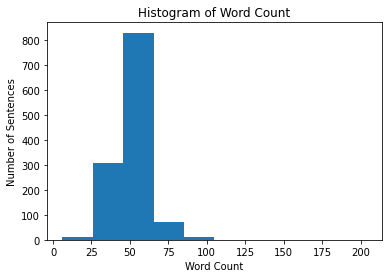

In [4]:
plot_histogram(data['Lyric'])

##### From the histogram, it is evident that most of the sentences have 50 words and some have 75. Although there are sentences with 100 words, the perecentage is very minimal. Hence maximum sequence length is considered as 75.

In [5]:
MAX_SEQ_LEN = 75
gpu, cpu = get_devices()

In [6]:
chk_point = 'bert-base-multilingual-cased'
base_model, tokenizer = load_bert_model(chk_point)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [7]:
sequences, attention_masks, targets = process_data_w_base_model(data, tokenizer, max_seq_len=MAX_SEQ_LEN)

In [8]:
txt_only_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.TXT,
                                       k_folds=5, epochs=15, balance_classes=True, dropout_level=0.1, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0, img_path=IMG_PATH, hidden_dim=256)

Running Text Only Classification
FOLD 0
Class Weights : [1.55520505 0.73692078]
Epoch 1 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.670 / Validation : 0.620


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time for epoch : 9.261425 seconds
Epoch 2 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.597 / Validation : 0.543
Time for epoch : 9.15377 seconds
Epoch 3 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.566 / Validation : 0.558
Time for epoch : 6.371066 seconds
Epoch 4 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.534 / Validation : 0.535
Time for epoch : 8.981851 seconds
Epoch 5 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.496 / Validation : 0.553
Time for epoch : 6.339416 seconds
Epoch 6 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.485 / Validation : 0.539
Time for epoch : 6.360754 seconds
Epoch 7 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.502 / Validation : 0.584
Time for epoch : 6.360714 seconds
Epoch 8 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.488 / Validation : 0.478


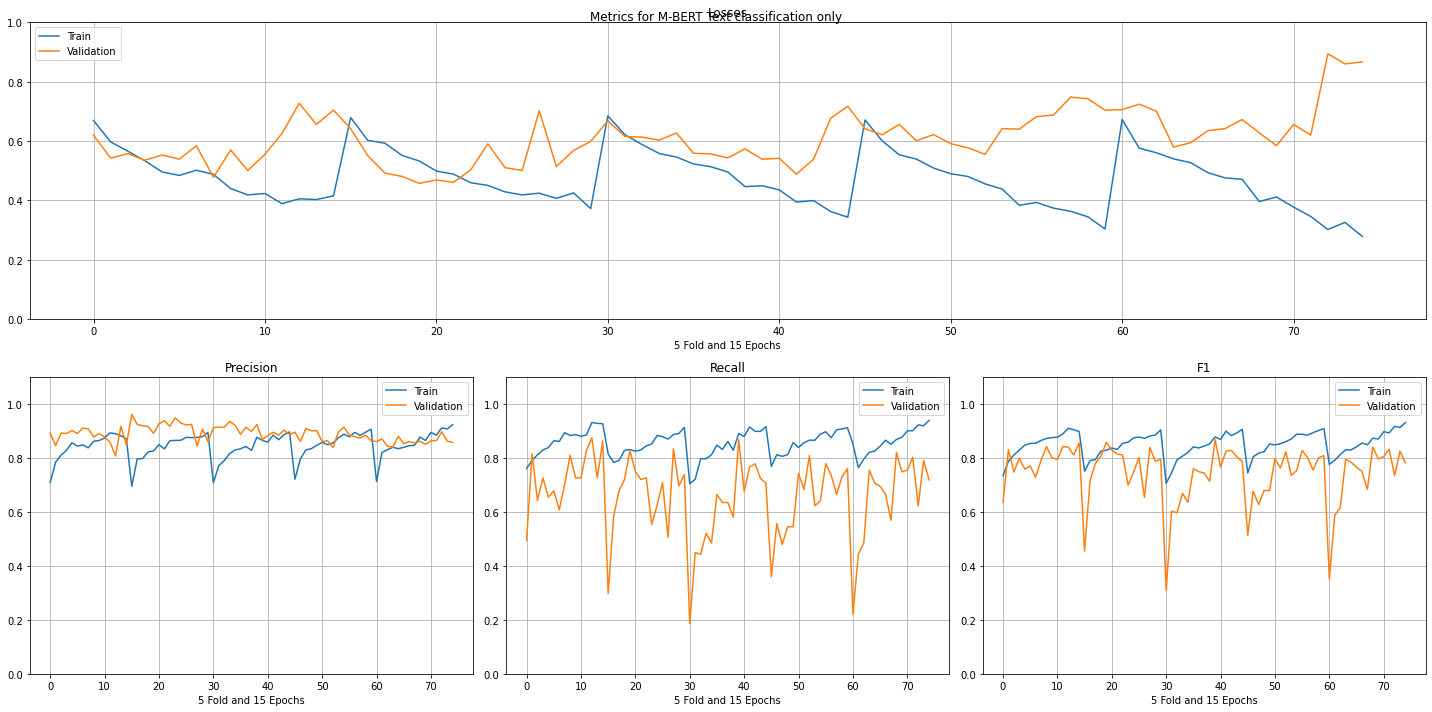

In [19]:
plot_results(txt_only_results[0], 'M-BERT Text classification only')

In [10]:
txt_only_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
9,0.877941,0.868263,0.865217,0.868263,0.891045,0.868263,0.449650,0.539069
4,0.828614,0.858025,0.826152,0.891026,0.831091,0.827381,0.533042,0.457692
14,0.897900,0.855457,0.870787,0.847953,0.926756,0.863095,0.415675,0.704359
11,0.888889,0.842424,0.892911,0.858025,0.884903,0.827381,0.389225,0.626364
8,0.872325,0.842105,0.861516,0.877419,0.883408,0.809524,0.440250,0.570014
...,...,...,...,...,...,...,...,...
1,0.791345,0.587302,0.820513,0.870588,0.764179,0.443114,0.576104,0.724443
0,0.744220,0.512821,0.721289,0.895522,0.768657,0.359281,0.671248,0.641692
0,0.750172,0.454545,0.695153,0.961538,0.814649,0.297619,0.679393,0.641990
0,0.776343,0.352381,0.712859,0.860465,0.852239,0.221557,0.672765,0.705965


In [11]:
mfcc_fusion_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.MFCC,
                                       k_folds=5, epochs=15, balance_classes=True, dropout_level=0.1, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0, img_path=IMG_PATH, hidden_dim=256)

Running Fusion Classification
FOLD 0
Class Weights : [1.55520505 0.73692078]
Epoch 1 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.687 / Validation : 0.662


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time for epoch : 9.842729 seconds
Epoch 2 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.623 / Validation : 0.558
Time for epoch : 9.212174 seconds
Epoch 3 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.565 / Validation : 0.577
Time for epoch : 6.538874 seconds
Epoch 4 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.515 / Validation : 0.636
Time for epoch : 6.504026 seconds
Epoch 5 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.531 / Validation : 0.595
Time for epoch : 6.48436 seconds
Epoch 6 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.493 / Validation : 0.603
Time for epoch : 6.497425 seconds
Epoch 7 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.501 / Validation : 0.590
Time for epoch : 6.503413 seconds
Epoch 8 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.477 / Validation : 0.626


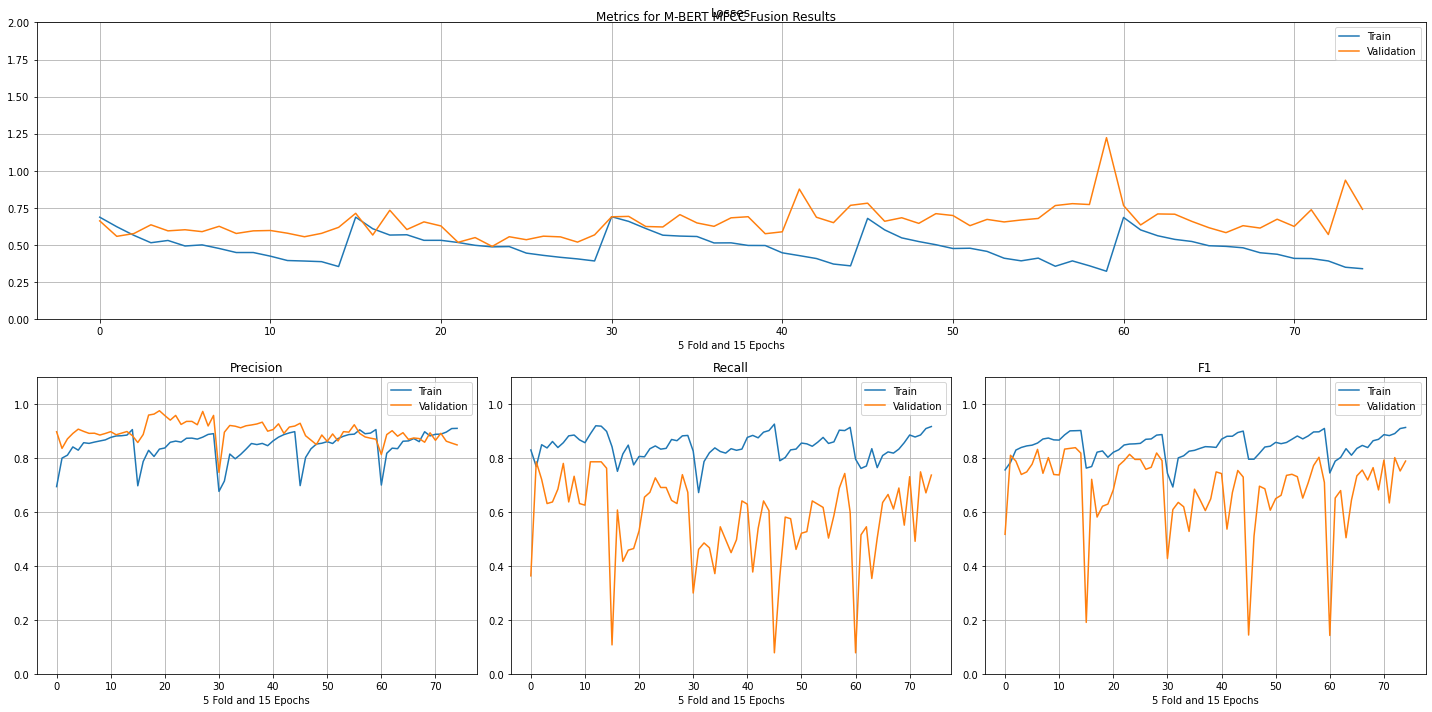

In [18]:
plot_results(mfcc_fusion_results[0],'M-BERT MFCC Fusion Results')

In [13]:
mfcc_fusion_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
13,0.900954,0.838095,0.884726,0.897959,0.917788,0.785714,0.387757,0.578470
12,0.900439,0.835443,0.882353,0.891892,0.919283,0.785714,0.391970,0.555619
11,0.885417,0.832808,0.881481,0.885906,0.889387,0.785714,0.395398,0.579508
6,0.855224,0.831746,0.853949,0.891156,0.856502,0.779762,0.500784,0.589943
13,0.884558,0.818482,0.887218,0.918519,0.881913,0.738095,0.406290,0.519477
...,...,...,...,...,...,...,...,...
3,0.834328,0.504274,0.834328,0.880597,0.834328,0.353293,0.537828,0.707522
0,0.743280,0.427350,0.676039,0.746269,0.825373,0.299401,0.690572,0.690145
0,0.762356,0.190476,0.696782,0.857143,0.841555,0.107143,0.687683,0.713506
0,0.795382,0.143646,0.697413,0.928571,0.925373,0.077844,0.679359,0.781802


In [14]:
mel_fusion_results = run_k_fold(base_model, gpu, data, sequences, attention_masks, targets, fusion=FusionTypes.MEL,
                                       k_folds=5, epochs=15, balance_classes=True, dropout_level=0.1, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=1, clip_at=1.0, img_path=IMG_PATH, hidden_dim=64)

Running Fusion Classification
FOLD 0
Class Weights : [1.55520505 0.73692078]
Epoch 1 / 15
Training Model


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:440: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /pytorch/aten/src/ATen/native/Convolution.cpp:660.)
  self.padding, self.dilation, self.groups)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ce

  Batch    50  of     62.
Evaluating
Losses - Train : 0.687 / Validation : 0.657


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time for epoch : 404.187065 seconds
Epoch 2 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.628 / Validation : 0.596
Time for epoch : 43.227135 seconds
Epoch 3 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.570 / Validation : 0.616
Time for epoch : 40.534142 seconds
Epoch 4 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.550 / Validation : 0.616
Time for epoch : 40.543868 seconds
Epoch 5 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.530 / Validation : 0.594
Time for epoch : 43.244571 seconds
Epoch 6 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.509 / Validation : 0.625
Time for epoch : 40.590459 seconds
Epoch 7 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.489 / Validation : 0.573
Time for epoch : 43.209553 seconds
Epoch 8 / 15
Training Model
  Batch    50  of     62.
Evaluating
Losses - Train : 0.459 / Validation

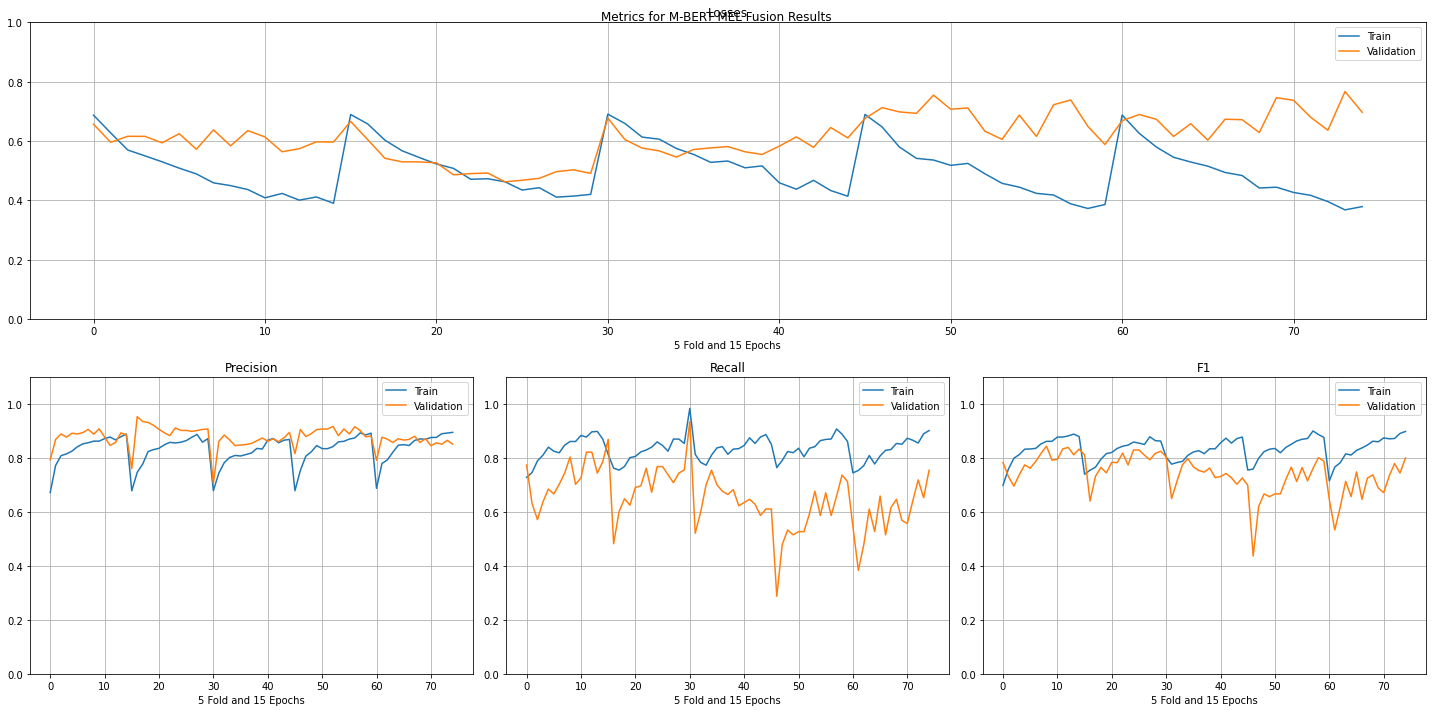

In [17]:
plot_results(mel_fusion_results[0],'M-BERT MEL Fusion Results')

In [16]:
mel_fusion_results[1].sort_values(by=['validation_f1', 'train_f1'], ascending=False)

,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
8,0.861631,0.843750,0.862275,0.888158,0.860987,0.803571,0.450040,0.584231
12,0.881705,0.838906,0.867052,0.857143,0.896861,0.821429,0.401181,0.574340
11,0.877429,0.833837,0.877429,0.846626,0.877429,0.821429,0.423712,0.564227
14,0.879154,0.832808,0.888550,0.885906,0.869955,0.785714,0.390594,0.596906
9,0.858850,0.829582,0.858209,0.902098,0.859492,0.767857,0.462959,0.462766
...,...,...,...,...,...,...,...,...
1,0.754438,0.640316,0.746706,0.952941,0.762332,0.482143,0.657698,0.604580
2,0.798794,0.620155,0.806697,0.879121,0.791045,0.479042,0.580510,0.698501
2,0.782148,0.617761,0.792945,0.869565,0.771642,0.479042,0.579943,0.673427
1,0.766313,0.533333,0.779321,0.876712,0.753731,0.383234,0.626028,0.689648
